In [1]:
import __init__

Navigated to package root: /home/cyprien/CrystaLLMv2_PKV
Added package root to Python path


### Preprocessing
- Dataset: Materials Project structures (April 2025)
  - Columns: Database, Reduced Formula, CIF, Bandgap (eV), Energy Above Hull (eV)
- Deduplicated, filters applied: 
  - removed negative and null bandgaps
- Cleaned for CIF augmentation, normalisations:
  - Bandgap - power-log ($\beta = 0.8$)
  - $E_{hull}$ - min-max
- Note: I didnt filter to context length here because it was not implemented yet, but filter to context was flagged as True during model training which effectively does the same thing (less efficient)
- Pushed to Huggingface as c-bone/mpdb-2prop_clean

### Training

In [ ]:
models = ['PKV', 'prepend', 'raw', 'slider']
regimes = ['ft', 'scratch']

for models in models:
    for regimes in regimes:
        config_path = f'_config_files/training/conditional/pretraining_benefits/mpdb_{regimes}-{models}.jsonc'

        !torchrun --nproc_per_node=2 _train.py --config config_path

### CIF Generation for each

In [ ]:
for models in models:
    for regimes in regimes:
        gen_config_path = f'_config_files/generation/conditional/pretraining_benefits/mpdb_{regimes}-{models}.jsonc'

        !python _utils/_generating/generate_CIFs.py --config gen_config_path

### Metrics for each

In [ ]:
for models in models:
    for regimes in regimes:
        gen_structs_path = f'_artifacts/pretrain_benefits/{regimes}-methods/mpdb_{regimes}-{models}_gen.parquet'

        postprocessed_path = f'_artifacts/pretrain_benefits/{regimes}-methods/mpdb-{regimes}-{models}_post.parquet'

        !python _utils/_metrics/VUN_metrics.py \
            --input_parquet gen_structs_path \
            --huggingface_dataset 'c-bone/mpdb-2prop_clean' \
            --load_processed_data 'HF-databases/mpdb-2prop_clean/mpdb_2prop_proc.parquet' \
            --output_parquet posprocessed_path \
            --num_workers 32

        !python _utils/_metrics/mace_ehull.py \
            --post_parquet posprocessed_path \
            --output_parquet posprocessed_path \
            --mp_data 'mp_computed_structure_entries.json.gz' \
            --num_workers 16

        !python _utils/_metrics/property_metrics.py \
            --post_parquet posprocessed_path \
            --output_parquet posprocessed_path \
            --property_targets ["Bandgap (eV)", "Energy Above Hull (eV)"] \
            --num_workers 16

### Plotting the results

In [ ]:
import __init__
import pandas as pd
from datasets import load_dataset
from __scripts_in_dev._plotting import pretraining_benefits

models = ['PKV', 'prepend', 'raw', 'slider']
regimes = ['ft', 'scratch']
dfs = {}
for models in models:
    for regime in regimes:
        if models == 'raw' and regime == 'ft':
            continue
        postprocessed_path = f'_artifacts/pretrain_benefits/{regime}-methods/mpdb-{regime}-{models}_post.parquet'
        # print(pd.read_parquet(postprocessed_path).columns)
        dfs[f'mpdb_{models}_{regime}'] = pd.read_parquet(postprocessed_path)

ds = load_dataset('c-bone/mpdb-2prop_clean', split='train')
train_df = ds.to_pandas()

Hit-rate vs density: hit_rate = 0.276·density + 0.026
Pearson's r = 0.780 (density vs hit_rate)
Avg Δ validity (pretrained-scratch): 0.204 ± 0.021 (SEM)
Avg Δ quality  (pretrained-scratch): 0.144 ± 0.009 (SEM)
Avg Δ hit_rate (pretrained-scratch): 0.026 ± 0.005 (SEM)
At 6.78 eV, best/worst hit_rate = 9.69×
Valid vs density: valid = 0.099·density + 0.478
Quality vs density: Q = 0.050·density + 0.072
Pearson's r = 0.173 (density vs valid)
Pearson's r = 0.216 (density vs quality)
Best run for mean hit_rate: PKV (pretrained) (0.226), 1.1% above Prepend (pretrained) (0.215)
Best run for mean valid: PKV (pretrained) (0.720), 1.1% above Prepend (pretrained) (0.709)
Best run for mean q: Prepend (pretrained) (0.198), 0.1% above PKV (pretrained) (0.196)


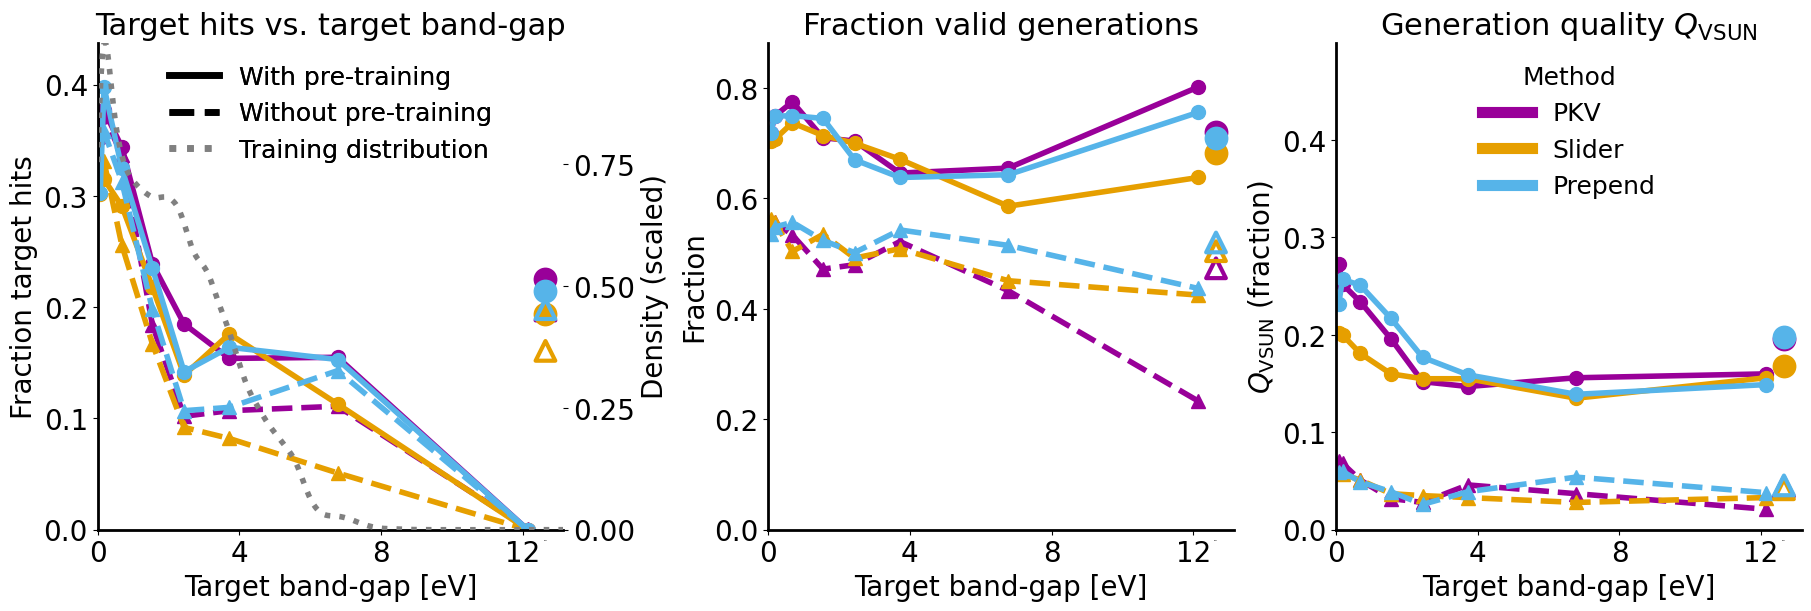

In [12]:
fig = pretraining_benefits(
    dfs,
    train_df=train_df,
    target_bg_col="target_Bandgap (eV)",
    savepath=None,
    xlim=(0,12.5),
    ylim_q=(0,0.5),
    hit_tol_eV=0.5,
    ylim_hit=None,
    ylim_valid=None,
    label_fontsize=20,
    title_fontsize=22,
    ticks_fontsize=20,
    legend_fontsize=18,
    mean_fontsize=0,
    line_width=4,
    marker_size=10,
    scatter_size=200,
    scatter_lw=3.0,
    axes_thickness=2
)


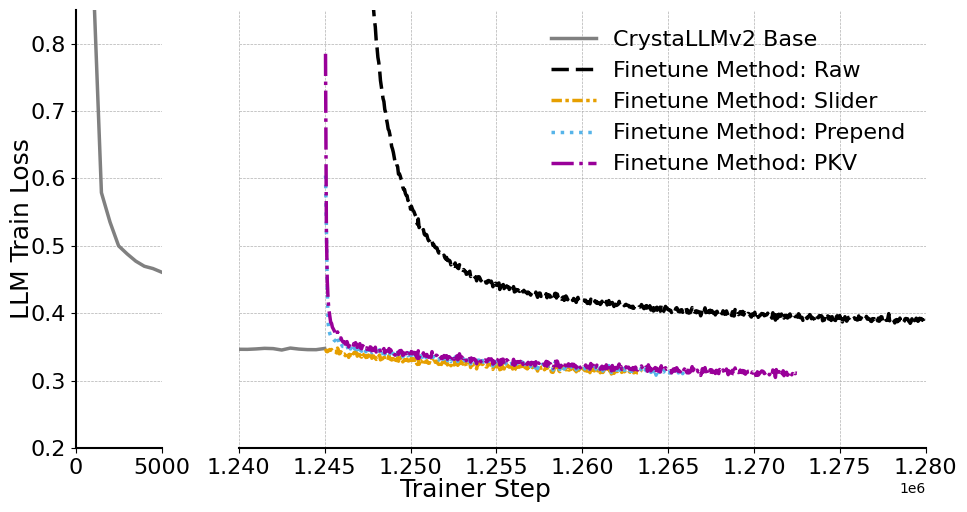

In [ ]:
from __scripts_in_dev._plotting import plot_losses

pretrained_model_losses = "model_ckpts/mpdb-small-base-lematerial/checkpoint-1245000/losses.json"
finetuned_models_losses = [
    "model_ckpts/pretraining_benefits/mpdb_2prop_ft/raw/checkpoint-50000/losses.json",
    "model_ckpts/pretraining_benefits/mpdb_2prop_ft/slider/checkpoint-18500/losses.json",
    "model_ckpts/pretraining_benefits/mpdb_2prop_ft/prepend/checkpoint-21000/losses.json",
    "model_ckpts/pretraining_benefits/mpdb_2prop_ft/PKV/checkpoint-27500/losses.json",
] 
output_path = "__old_files/test.png"

plot_losses(
    pretrained_model_losses,
    finetuned_models_losses,
    output_path,
    window=5000,
    ymin=0.20,
    ymax=0.85,
    figsize=(10, 6),
    label_fontsize=18,
    ticks_fontsize=16,
    legend_fontsize=16,
    line_width=2.5,
    axes_linewidth=1.5,
    num_xticks=4,
    num_yticks=4
)